# Figure 4: Control Range
In this Notebook, we shall create a plot showing how control performed through a Spike Coding Network (SCN) is affected by sensor noise and an input pulse. The plot shows two Spring-Mass-Damper (SMD) systems, of which one is controlled through an SCN estimator and controller, and the other through an idealized LQG controller. Both controllers are affected by the same disturbances. The work in this notebook is carried out for "Closed-form control with spike coding networks" by F.S. Slijkhuis, S.W. Keemink and P. Lanillos (https://doi.org/10.48550/arXiv.2212.12887).

## Imports
Nothing too special here, we shall use Numpy for matrices and Matplotlib for plotting. The Python-files initialization.py and simulation.py contain helper functions which will prevent clutter in this notebook. Please refer to the files themselves to learn more about the functions within them. Joblib is used for parallelization of code. Tqdm is used for progress bars. Numba is used for code optimization, making it faster.

In [1]:
import numpy as np #Numpy for matrix calculations
import matplotlib.pyplot as plt #Matplotlib for plotting
import initialization, simulation #Helper functions for initialization and simulation are located in these two Python files. Please see the files themselves for more details.

from tqdm.notebook import trange,tqdm #Progress bars
from joblib import Parallel, delayed #Parallelization of code
import numba as nb #Numba for code optimization

## Initialization
For initialization, we shall define parameters relevant to the simulations in this notebook. As mentioned earlier, we are simulating two SMD systems: one controlled using an SCN controller and the other through an idealized LQG. Both the controllers and SMD systems will be simulated using Forward Euler. But first, we must define the relevant parameters.

Because we are running multiple simulations with different parameters, we will put the initialization inside a function, so that we can call it with different parameters.

In [2]:
def init_controlrange(sensornoise):
    #Forward Euler parameters
    time = 5 #Total simulation time in seconds
    dt = 0.0001 #Length of a single timestep

    #Spring-Mass-Damper System(s) parameters
    m = 3 #Mass (in kg)
    k = 5 #Spring constant (in N/m)
    c = 0.5 #Constant of proportionality (dampening, in Ns/m = kg/s)
    x0 = np.array([0, 0]) #Initial state of the SMD system.

    #Other system parameters
    C = np.array([[1,0],
                [0,0]]) #Initialization of the C matrix (because y=Cx+noise)
    Vn_cov = sensornoise #Sensor noise covariance (y=Cx+noise)
    Vd_cov = 0.001 #Disturbance noise covariance (noise on the SMD)

    #SCN Controller parameters
    network_size = 50 #The number of neurons in the SCN
    signal_dimensions = 4 #The dimensions of the signal, which is 4 here because the target state is also encoded into the network
    lam = 0.1 #The leakage constant of the network, lambda
    Vv_sigma = 0.000001 #Voltage noise sigma; noise on the voltage

    #Control parameters
    Q = np.array([[10,0],
                [0,1]]) #The Q-matrix, cost of deviations from the state
    R = 0.001 #Cost of actuation
    
    #Forward Euler simulation
    times,Nt = initialization.FE_init(time,dt) #times is a list of timesteps which we will loop over, Nt is the total number of timesteps (length of times)

    #SMD System A and B matrices
    A,B = initialization.SMD_init(m,k,c) #A and B are the system matrix and input matrix in state-space representation (according to Ax+Bu)

    #Initialization of the Kalman filter gain matrix to be used inside of the SCN estimator and idealized Kalman filter
    Kf = initialization.Kalman_init(A,C,Vn_cov,Vd_cov) #From the A and C matrices and noise covariances, we can calculate the Kalman filter gain matrix

    #Initialization of the LQR gain matrix to be used inside of the SCN controller and idealized LQG
    Kc = initialization.Control_init(A,B,Q,R)

    #Initialization of the state-matrices, containing the states of the simulated SMD systems over time
    X = initialization.X_init(x0,Nt) #Requires x0 as the first state of the simulated SMD system, and Nt for the matrix dimensions
    X_2 = initialization.X_init(x0,Nt) #We run two SMD systems with different controllers, so we need two state matrices

    #Initializaton of the SCN controller, given parameters, we calculate D, T, V, s, r and all of the connectivity
    D,T,V,s,r,O_f,O_s,O_c,F_c,O_k,F_k = initialization.ControllerSCN_init(signal_dimensions,Nt,A,B,C,Kf,Kc,network_size,lam)


    #Target state parameters
    x0_des = np.full([Nt+1],0) # Desired x0, position.
    x1_des = np.full([Nt+1],0) # Desired x1, velocity.

    x_des = np.array([x0_des,x1_des]) #Desired states over time.


    #Error matrices, will be updated during the simulation
    error_ideal=np.zeros([len(x0),Nt+1]) #Error between idealzied LQG and SMD system
    error_scn=np.zeros([len(x0),Nt+1]) #Error between SCN controller and SMD system

    #Initialization of other matrices used in simulation, U, Y, X_hat (state matrix of SCN estimator), X_hat_fe (state matrix of idealized Kalman filter), uDIST and uNOISE (noise matrices)
    U,Y,U_2,Y_2,X_hat,X_hat_fe,uDIST,uNOISE,Dx,error_scn,error_ideal = initialization.ControlLoop_init(X,X_2,error_scn,error_ideal,x_des,dt,A,B,C,x0,Nt,Vd_cov,Vn_cov)
    
    return Nt,X,X_2,A,B,U,U_2,uDIST,dt,Y,Y_2,C,uNOISE,r,s,V,D,T,lam,O_f,O_s,O_c,F_c,O_k,F_k,Vv_sigma,X_hat,X_hat_fe,Kf,Kc,x_des,error_scn,error_ideal,signal_dimensions,Dx

## Simulation
Now that we have defined all of the parameters we need, we can define how to run the simulation with Numba. For Numba, we put everything in a single function.

In [3]:
@nb.jit(nopython=True)
def run_simulation(Nt,X,A,B,U,uDIST,dt,X_2,U_2,error_scn,error_ideal,Y,C,uNOISE,Y_2,r,s,V,x_des,Dx,D,T,lam,Kc,O_f,O_s,O_c,F_c,O_k,F_k,voltage_noise_sigma,Kf,X_hat_fe,pulse_strength):
    #Looping over the entire range of Nt, we have all the timesteps in our simulation
    for t in range(Nt):
            #First, simulate one step of both simulated SMD system, but if a pulse should occur, add it to the systems (when if-statement is true)
            #Code for X, the first SMD system controlled by SCN controller
            if t in range(int(Nt/2)-25,int(Nt/2)+25):
                dxdt = A@X[:,t] + B@U[:,t] + pulse_strength + np.sqrt(dt)*uDIST[:,t]
            else:
                dxdt = A@X[:,t] + B@U[:,t] + np.sqrt(dt)*uDIST[:,t]
            X[:,t+1] = X[:,t] + dxdt*dt
            
            #Code for X_2, the second SMD system controlled by idealized LQG
            if t in range(int(Nt/2)-25,int(Nt/2)+25):
                dxdt = A@X_2[:,t] + B@U_2[:,t] + pulse_strength + np.sqrt(dt)*uDIST[:,t]
            else:
                dxdt = A@X_2[:,t] + B@U_2[:,t] + np.sqrt(dt)*uDIST[:,t]
            X_2[:,t+1] = X_2[:,t] + dxdt*dt
            
            #Update the error matrices
            error_scn[:,t+1] = np.abs(X[:,t+1]-x_des[:,t+1])
            error_ideal[:,t+1] = np.abs(X_2[:,t+1]-x_des[:,t+1])

            #Our controllers only have access to Y, which is the partially observable state plus noise
            Y[:,t+1] = C[0]*X[:,t+1] + uNOISE[:,t+1]
            Y_2[:,t+1] = C[0]*X_2[:,t+1] + uNOISE[:,t+1]
            
            #Obtaining the U from the network
            U[:,t+1] = -Kc @ (D[:-2] @ r[:,t] - D[2:] @ r[:,t])

            #Calculating the voltages at time t+1
            dvdt = -lam * V[:,t] - O_f @ s[:,t] + O_s @ r[:,t] + (O_c @ r[:,t] + F_c @ D[2:] @ r[:,t]) - (O_k @ r[:,t] + np.dot(F_k,C[0]*Y[:,t]))
            dvdt = dvdt + (D[2:].T @ ((lam*x_des[:,t])+Dx[:,t])) - (D[2:].T @ D[2:] @ s[:,t])
            V[:,t+1] = V[:,t] + dvdt*dt + np.sqrt(dt)*voltage_noise_sigma*np.random.randn(len(dvdt))

            #Check if there are neurons whose voltage is above threshold
            above = np.where(V[:,t+1] > T)[0]

            #Introduce a control to let only one neuron fire at the time
            s[:,t+1]=np.zeros(s[:,t].shape)
            if len(above):
                s[:,t+1][np.argmax(V[:,t+1])] = 1/dt

            #Update firing rates
            drdt = s[:,t+1] - lam*r[:,t]
            r[:,t+1] = r[:,t] + drdt*dt
            
            #Run a step of the idealized controller which we compare the SCN to
            dxdt = A@X_hat_fe[:,t] + B@U_2[:,t] + Kf@(Y_2[:,t]-(C[0]*X_hat_fe[:,t]))
            X_hat_fe[:,t+1] = X_hat_fe[:,t] + dxdt*dt
            
            #U_2 is the control signal of the idealized controller
            U_2[:,t+1] = -Kc@(X_hat_fe[:,t+1]-x_des[:,t])
            
    return X,X_2,error_scn,error_ideal,U,U_2,Y

Next, we define how to run a single simulation with parameters.

In [4]:
def single_sim(sensornoise,pulse_strength):
    #Obtain parameters of simulation
    Nt,X,X_2,A,B,U,U_2,uDIST,dt,Y,Y_2,C,uNOISE,r,s,V,D,T,lam,O_f,O_s,O_c,F_c,O_k,F_k,Vv_sigma,X_hat,X_hat_fe,Kf,Kc,x_des,error_scn,error_ideal,signal_dimensions,Dx = init_controlrange(sensornoise)

    #Run simulation with parameters
    X_SCN,X_ideal,error_scn,error_ideal,U,U_2,Y = run_simulation(Nt,X,A,B,U,uDIST,dt,X_2,U_2,error_scn,error_ideal,Y,C,uNOISE,Y_2,r,s,V,x_des,Dx,D,T,lam,Kc,O_f,O_s,O_c,F_c,O_k,F_k,Vv_sigma,Kf,X_hat_fe,pulse_strength)
    
    #Apply the pulse strength to the U-matrices (U and U_2), so that we can plot when the pulse happens
    pulse_strength_list = np.zeros([B.shape[1],Nt+1])
    pulse_strength_list[:,int(Nt/2)-25:int(Nt/2)+25]=pulse_strength
    U_with_pulse=U+pulse_strength_list
    U_2_with_pulse=U_2+pulse_strength_list
    
    #We return the averages of the errors, as well as some other stuff useful for debugging or for plotting
    return np.average(error_scn,axis=1),np.average(error_ideal,axis=1),U,U_2,U_with_pulse,U_2_with_pulse,X_SCN,X_ideal,pulse_strength_list,x_des,Y

Last, we run the multiple simulations with our specified parameter range.

In [5]:
#Grid search
n_sensornoise = [1e-5,1e-4,1e-3,1e-2,1e-1] #List of sensor noises to compare
n_pulse_strength = range(0,1000,100) #List of pulse_strengths to compare
error_list = {}

#Run the simulations in parallel using joblib
for i,sensornoise in tqdm(enumerate(n_sensornoise),total=len(n_sensornoise)):
    error_list[i] = Parallel(n_jobs=-1)(delayed(single_sim)(sensornoise, pulse_strength) for pulse_strength in n_pulse_strength)
    
#What we obtained was a list of all the values, but we have to obtain the relevant values again for the plots. These will be the error in the position for both the SCN controller and the idealized controller.
scn_avg_pos_error=[]
for i,sensor in enumerate(n_sensornoise):
    x_scn_ax=[]
    for j, pulse_strength in enumerate(n_pulse_strength):
        x_scn_ax.append(error_list[i][j][0][0])
    scn_avg_pos_error.append(x_scn_ax)
    
ideal_avg_pos_error=[]
for i,sensor in enumerate(n_sensornoise):
    x_ideal_ax=[]
    for j, pulse_strength in enumerate(n_pulse_strength):
        x_ideal_ax.append(error_list[i][j][1][0])
    ideal_avg_pos_error.append(x_ideal_ax)

  0%|          | 0/5 [00:00<?, ?it/s]

## Plotting
Now that we have obtained our filled state matrices, we can plot everything. First, the colorbar plots.

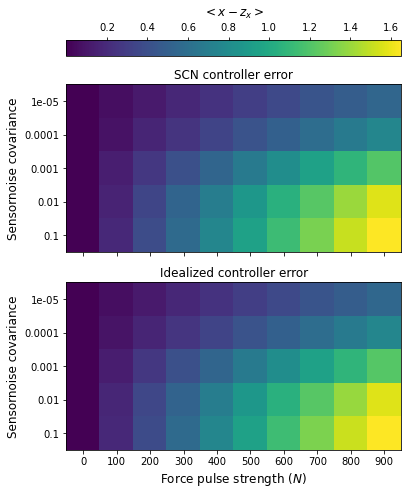

In [6]:
fig, axs = plt.subplots(2,1, sharex= True, gridspec_kw = {'hspace':0.1,'height_ratios':[1.3,1]})
fig.set_figheight(8)
fig.set_figwidth(6)

legend=[]
axs[0].imshow(scn_avg_pos_error,vmax=1.65)
axs[0].set_xticks(range(len(n_pulse_strength)))
axs[0].set_xticklabels(n_pulse_strength)
axs[0].set_yticks(range(len(n_sensornoise)))
axs[0].set_yticklabels(n_sensornoise)
axs[0].set_ylabel('Sensornoise covariance',fontsize = 12)
axs[0].set_title('SCN controller error')

legend=[]
im=axs[1].imshow(ideal_avg_pos_error,vmax=1.65)
axs[1].set_xticks(range(len(n_pulse_strength)))
axs[1].set_xticklabels(n_pulse_strength)
axs[1].set_yticks(range(len(n_sensornoise)))
axs[1].set_yticklabels(n_sensornoise)
axs[1].set_xlabel('Force pulse strength ($N$)',fontsize = 12)
axs[1].set_ylabel('Sensornoise covariance',fontsize = 12)
axs[1].set_title('Idealized controller error')

colorbar = plt.colorbar(im,ax=axs[0],location="top",orientation="horizontal",pad=0.12)
colorbar.ax.set_title("$<x-z_x>$",fontsize=12)

plt.savefig('./img/fig4a.png', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.show()

Next, the supplementary plots which show the effect of different parameter values on the SCN.

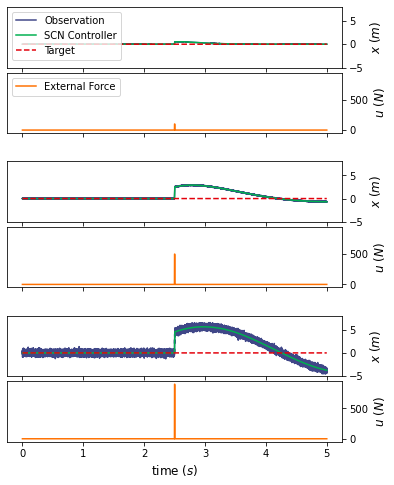

In [9]:
fig, axs = plt.subplots(8,1, sharex=True, squeeze=True, gridspec_kw = {'hspace':0.1,'height_ratios':[1,1,0.3,1,1,0.3,1,1]})
fig.set_figheight(8)
fig.set_figwidth(6)
legend_fontsize=10

#Forward Euler parameters
time = 5 #Total simulation time in seconds
dt = 0.0001 #Length of a single timestep

axs[2].set_visible(False)
axs[5].set_visible(False)

legend=[]
axs[0].plot(np.arange(0,time+dt,dt),error_list[0][1][10][0],color='#404788FF')
legend.append("Observation")
axs[0].plot(np.arange(0,time+dt,dt),error_list[0][1][6][0],color='#00B050')
legend.append("SCN Controller")
axs[0].plot(np.arange(0,time+dt,dt),error_list[0][1][9][0],linestyle='dashed',color='#E3000B')
legend.append("Target")
axs[0].legend(legend,fontsize=legend_fontsize,loc='upper left')
axs[0].set_ylabel('$x$ $(m)$',fontsize = 12)
axs[0].yaxis.tick_right()
axs[0].yaxis.set_label_position("right")
axs[0].yaxis.set_label_position("right")
axs[0].set_ylim(-5, 8)

legend=[]
axs[1].plot(np.arange(0,time+dt,dt),error_list[0][1][8][0],color='#FF7101')
legend.append("External Force")
axs[1].legend(legend,fontsize=legend_fontsize,loc='upper left')
axs[1].set_ylabel('$u$ $(N)$',fontsize = 12)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].set_ylim(-50, 950)


legend=[]
axs[3].plot(np.arange(0,time+dt,dt),error_list[2][5][10][0],color='#404788FF')
legend.append("Observation")
axs[3].plot(np.arange(0,time+dt,dt),error_list[2][5][6][0],color='#00B050')
legend.append("SCN Controller")
axs[3].plot(np.arange(0,time+dt,dt),error_list[2][5][9][0],linestyle='dashed',color='#E3000B')
legend.append("Target")
axs[3].set_ylabel('$x$ $(m)$',fontsize = 12)
axs[3].yaxis.tick_right()
axs[3].yaxis.set_label_position("right")
axs[3].set_ylim(-5, 8)

legend=[]
axs[4].plot(np.arange(0,time+dt,dt),error_list[2][5][8][0],color='#FF7101')
legend.append("External force")
axs[4].set_ylabel('$u$ $(N)$',fontsize = 12)
axs[4].yaxis.tick_right()
axs[4].yaxis.set_label_position("right")
axs[4].set_ylim(-50, 950)


legend=[]
axs[6].plot(np.arange(0,time+dt,dt),error_list[4][9][10][0],color='#404788FF')
legend.append("Observation")
axs[6].plot(np.arange(0,time+dt,dt),error_list[4][9][6][0],color='#00B050')
legend.append("SCN Controller")
axs[6].plot(np.arange(0,time+dt,dt),error_list[4][9][9][0],linestyle='dashed',color='#E3000B')
legend.append("Target")
axs[6].set_ylabel('$x$ $(m)$',fontsize = 12)
axs[6].yaxis.tick_right()
axs[6].yaxis.set_label_position("right")
axs[6].set_ylim(-5, 8)

legend=[]
axs[7].plot(np.arange(0,time+dt,dt),error_list[4][9][8][0],color='#FF7101')
legend.append("External force")
axs[7].set_ylabel('$u$ $(N)$',fontsize = 12)
axs[7].set_xlabel('time ($s$)',fontsize = 12)
axs[7].yaxis.tick_right()
axs[7].yaxis.set_label_position("right")
axs[7].set_ylim(-50, 950)

plt.savefig('./img/fig4b.png', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.show()